In [1]:
%load_ext autoreload
%autoreload 2
%env PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj
%matplotlib inline


env: PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj


In [2]:

import skimage
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.ops import cascaded_union

In [3]:
import solaris as sol

In [4]:
from tqdm import tqdm
from skimage.external import tifffile as sktif

# import shapely.wkt
# import geopandas as gpd
import numpy as np
import cv2
from functools import partial

from fastai.imports import *
from fastai.vision import *
from fastai.metrics import dice
from fastai.callbacks import *

# from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import functools, traceback
def gpu_mem_restore(func):
    "Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"
from importlib import reload

In [5]:
data_dir = Path("/media/wwymak/Storage/spacenet_roads")
train_dir = data_dir / "AOI_3_Paris_Roads_Train"
# small image/mask tiles made in space_net_roads_nvidia.ipynb
rgb_256 = train_dir / "rgb_256"

mask_256 = train_dir / "mask_256"

In [6]:
mask_with_roads_256 = train_dir / "mask_with_roads_256"

mask_ids = [f.name for f in mask_with_roads_256.ls()]
mask_ids[:5]

['mask_256_AOI_3_Paris_img310_1_1.png',
 'mask_256_AOI_3_Paris_img55_4_3.png',
 'mask_256_AOI_3_Paris_img235_3_1.png',
 'mask_256_AOI_3_Paris_img153_2_3.png',
 'mask_256_AOI_3_Paris_img295_4_3.png']

In [7]:
valid_imgs = [f.replace('mask', 'rgb').replace('png', 'tif') for f in mask_ids]

In [8]:
img_ids = list(set(['_'.join(f.replace('mask_256_', '').replace('.png', '').split('_')[:-2]) for f in mask_ids]))
img_ids.sort()
img_ids[:5]

['AOI_3_Paris_img10',
 'AOI_3_Paris_img100',
 'AOI_3_Paris_img101',
 'AOI_3_Paris_img103',
 'AOI_3_Paris_img11']

In [9]:
validation_imgs_parent = np.random.choice(img_ids,size=int(256 * 0.2), replace=False)
train_imgs_parent = list(set(img_ids) - set(validation_imgs_parent))
train_imgs_parent[:5], validation_imgs_parent[:5]

(['AOI_3_Paris_img359',
  'AOI_3_Paris_img427',
  'AOI_3_Paris_img450',
  'AOI_3_Paris_img389',
  'AOI_3_Paris_img417'],
 array(['AOI_3_Paris_img14', 'AOI_3_Paris_img26', 'AOI_3_Paris_img227', 'AOI_3_Paris_img130', 'AOI_3_Paris_img179'],
       dtype='<U18'))

In [10]:

def get_mask_fn(fname):
    return mask_with_roads_256 / fname.name.replace("rgb", "mask").replace("tif", "png")

def get_tiles(img_id_list, filepath):

    filename = Path(filepath).name
    img_id = "_".join(filename.replace('rgb_256_', '').split("_")[:4])
    return img_id in img_id_list

codes = ["background", "road"]


bs = 16
size=128
src = (SegmentationItemList.from_folder(rgb_256)
       .filter_by_func(lambda fname: get_tiles(list(set(img_ids)), fname) and Path(fname).name in valid_imgs)
       .split_by_valid_func(lambda fname: get_tiles(validation_imgs_parent, fname))
       .label_from_func(get_mask_fn, classes=codes)
      )


data = (src.transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

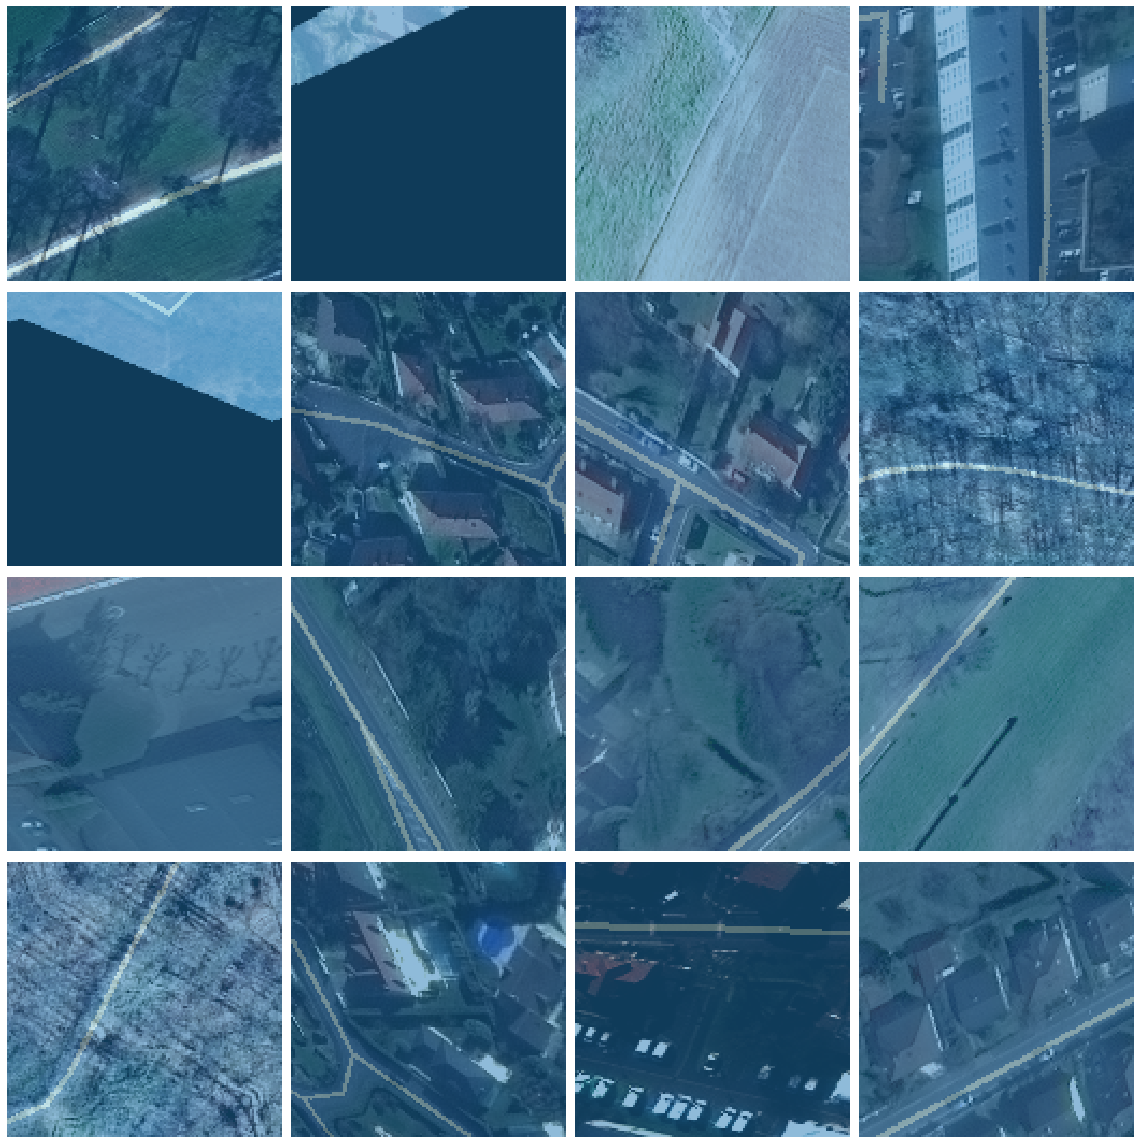

In [11]:
data.show_batch()

In [11]:
class TorchCompositeLoss(nn.Module):
    """Composite loss function."""

    def __init__(self, loss_dict, weight_dict=None):
        """Create a composite loss function from a set of pytorch losses."""
        super().__init__()
        self.weights = weight_dict
        self.losses = {loss_name: sol.nets.losses.get_single_loss('pytorch',
                                                  loss_name,
                                                  loss_params)
                       for loss_name, loss_params in loss_dict.items()}
        self.values = {}  # values from the individual loss functions

    def forward(self, outputs, targets):
        loss = 0
        logits = outputs[:, 1, :, :].float()
        targets = targets.squeeze(1).float()
        for func_name, weight in self.weights.items():
            self.values[func_name] = self.losses[func_name](logits, targets)
            loss += weight*self.values[func_name]

        return loss



In [11]:
class TorchFocalLoss(nn.Module):
    """Implementation of Focal Loss[1]_ modified from Catalyst [2]_ .

    Arguments
    ---------
    gamma : :class:`int` or :class:`float`
        Focusing parameter. See [1]_ .
    alpha : :class:`int` or :class:`float`
        Normalization factor. See [1]_ .

    References
    ----------
    .. [1] https://arxiv.org/pdf/1708.02002.pdf
    .. [2] https://catalyst-team.github.io/catalyst/
    """

    def __init__(self, gamma=2, alpha=0.25):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, outputs, targets):
        """Calculate the loss function between `outputs` and `targets`.

        Arguments
        ---------
        outputs : :class:`torch.Tensor`
            The output tensor from a model.
        targets : :class:`torch.Tensor`
            The training target.

        Returns
        -------
        loss : :class:`torch.Variable`
            The loss value.
        """
        
        
        if targets.size() != outputs.size():
            raise ValueError(
                f"Targets and inputs must be same size. "
                f"Got ({targets.size()}) and ({outputs.size()})"
            )

        max_val = (-outputs).clamp(min=0)
        log_ = ((-max_val).exp() + (-outputs - max_val).exp()).log()
        loss = outputs - outputs * targets + max_val + log_

        invprobs = F.logsigmoid(-outputs * (targets * 2.0 - 1.0))
        loss = self.alpha*(invprobs * self.gamma).exp() * loss

        return loss.sum(dim=-1).mean()

In [19]:
def combined_loss(outputs, targets):
    outputs = outputs[:, 1, :, :].float() - outputs[:, 0, :, :].float()
    targets = targets.squeeze(1).float()
    
    focal_loss = TorchFocalLoss()(outputs, targets)
    bce = nn.BCEWithLogitsLoss()(outputs, targets)
    
    return 0.8 * focal_loss + 0.2 * bce

In [23]:
wd = 1e-2
learn = unet_learner(data, models.resnet34, metrics=[partial(dice, iou=True),
                             partial(foreground_acc, void_code=0)], wd=wd, bottle=True, 
                     loss_func=combined_loss).to_fp16()

In [24]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.92E-06
Min loss divided by 10: 3.31E-03


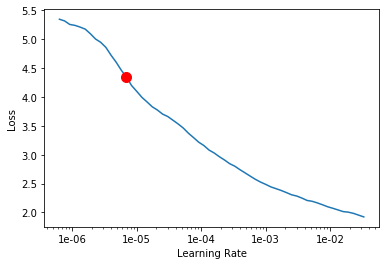

In [25]:
learn.recorder.plot(suggestion=True)

In [26]:
lr=1e-4
learn.fit_one_cycle(20, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,dice,foreground_acc,time
0,1.117184,0.983096,0.003295,0.003543,00:13
1,0.907831,0.829124,0.007794,0.008197,00:12
2,0.795538,0.740369,0.016592,0.017703,00:13
3,0.729079,0.683933,0.015136,0.015924,00:13
4,0.699773,0.654434,0.011581,0.011974,00:13
5,0.667671,0.694500,0.000075,0.000075,00:13
6,0.667433,0.628675,0.001053,0.001055,00:13
7,0.661913,0.605668,0.001943,0.001950,00:13
8,0.647174,0.580334,0.007223,0.007312,00:13
9,0.638768,0.620262,0.001595,0.001600,00:13
